In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.utils import resample
import math
from gensim.models import KeyedVectors
import datafold.dynfold as dfold
import datafold.pcfold as pfold
from datafold.dynfold import LocalRegressionSelection
from datafold.utils.plot import plot_pairwise_eigenvector
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.manifold import trustworthiness
from utilities import *
from adjustText import adjust_text
from matplotlib.ticker import MaxNLocator
from plot_functions import *


In [4]:
# download dataset from:https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing
# import dataset
file_path = 'GoogleNews-vectors-negative300.bin.gz'
word_vectors = KeyedVectors.load_word2vec_format(file_path, binary=True)

1 Computational efficiency and RAM requirement

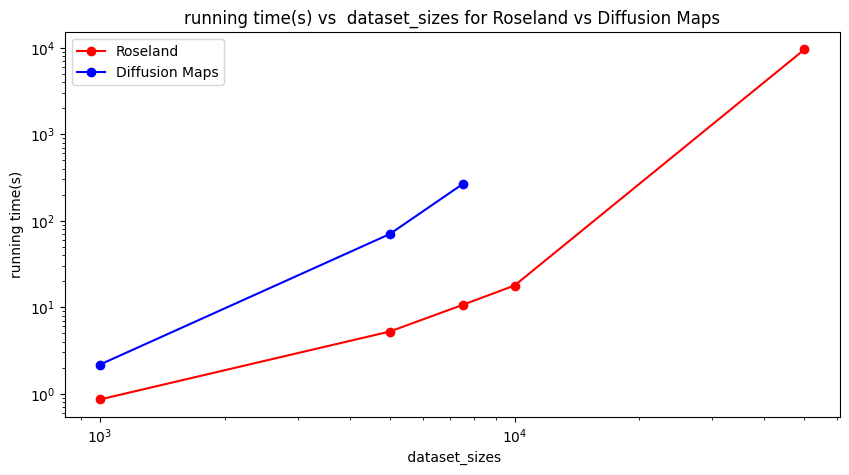

In [7]:

dataset_sizes_dm = [1000,5000,7500]
dataset_sizes_r = [1000,5000, 7500,10000, 50000]
dm_times = []
r_times = []
for N in dataset_sizes_dm:
  X_pcm = preprocess_w2v(word_vectors,N)
  dm_time = run_time(X_pcm,'dm')
  dm_times.append(dm_time)
for N in dataset_sizes_r:
  X_pcm = preprocess_w2v(word_vectors,N)
  r_time = run_time(X_pcm,'r')
  r_times.append(r_time)
plot_vs(dataset_sizes_r,r_times,dm_times,' dataset_sizes','running time(s)')


2 Illustration and ajusting the number of eigenvector for Diffusion map (svdvector for Roseland)

2.1 Using a designed dataset to illustrate the ideal 2d embedding of Word2Vec dataset

epsilon=1.2135417479391282, cut-off=4.728029727935791


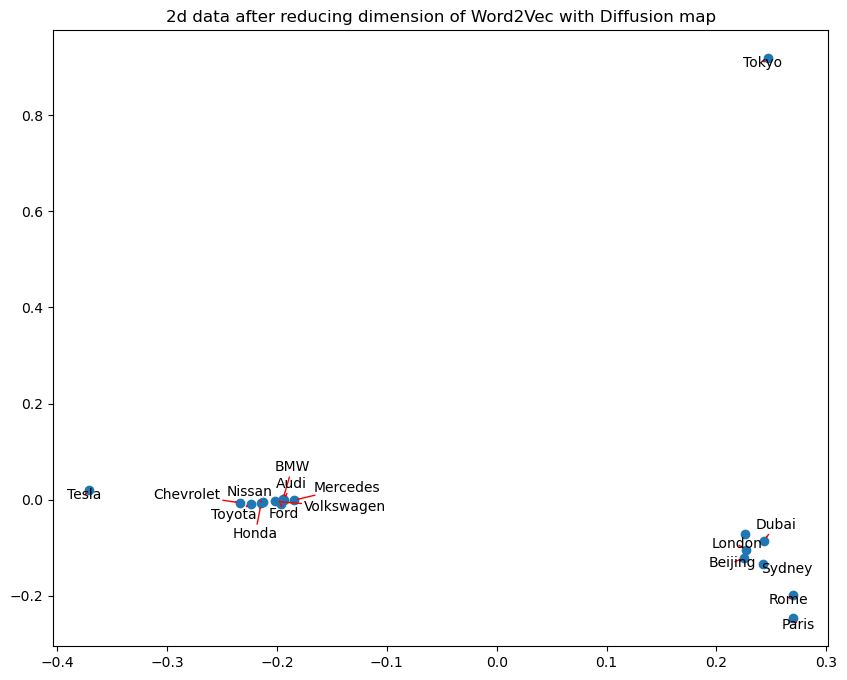

In [11]:


# Define the list of words to visualize, replace with the actual words you're interested in
words = [
    # About pandas
    # About car companies
    "Toyota", "Ford", "Tesla", "BMW", "Mercedes", "Honda", "Audi", "Volkswagen", "Nissan", "Chevrolet",
    # About popular city names
    "New York", "London", "Paris", "Tokyo", "Dubai", "Sydney", "Rome", "Beijing", "Los Angeles", "Berlin"]

# Retrieve the word vectors
vectors = np.array([word_vectors[word] for word in words if word in word_vectors])
X_pcm = preprocess_w2v(vectors,len(words),designed_flag=True)

# Perform dimensionality reduction using datafold
target_mapping_dm = diffusion(X_pcm,n_eigenp=7,intrinsic_dim=2)
# Visualize the reduced word vectors
plot_scatter(target_mapping_dm,words,word_vectors,'Diffusion map',text_flag=True)


2.2 Illustrating Suboptimal 2d embedding result of both two algorithms with scatter

epsilon=1.4222524945784134, cut-off=5.1184821128845215


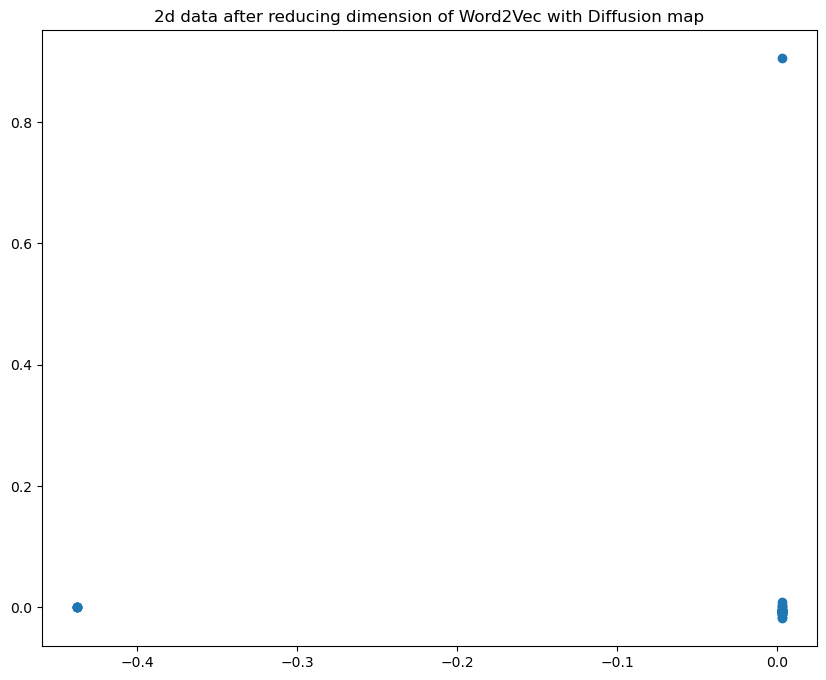

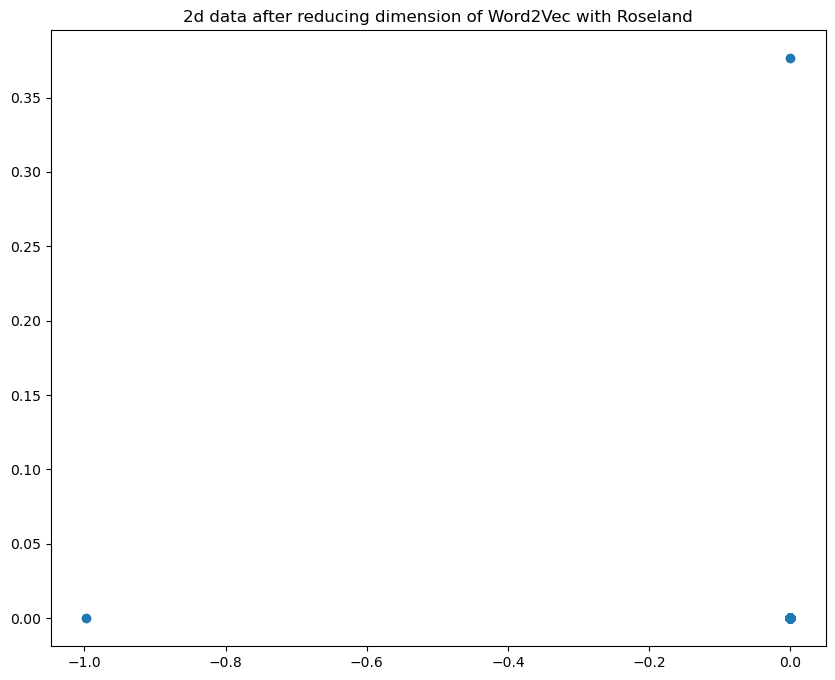

In [15]:

# Perform dimensionality reduction using datafold
dataset_size = 5000
X_pcm = preprocess_w2v(word_vectors,dataset_size)
# Trustworthiness_score
target_mapping_dm = diffusion(X_pcm,n_eigenp=7,intrinsic_dim=2)
# Visualize the reduced word vectors
plot_scatter(target_mapping_dm,word_vectors,'Diffusion map',text_flag=False)

target_mapping_r = roseland(X_pcm,n_svdtriplet=7,intrinsic_dim=2)
plot_scatter(target_mapping_r,word_vectors,'Roseland',text_flag=False)



2.3 Suboptimal 2d embedding result of both two algorithms with trustworthiness

In [16]:

trustworthiness_score_dm = trustworthiness(X_pcm, target_mapping_dm, n_neighbors=4)
print('trustworthiness_score_dm',trustworthiness_score_dm)
trustworthiness_score_r = trustworthiness(X_pcm, target_mapping_r, n_neighbors=4)
print('trustworthiness_score_r',trustworthiness_score_r)


trustworthiness_score_dm 0.5265679583458496
trustworthiness_score_r 0.5295041453890057


2.4 Looking for number of eigenpair

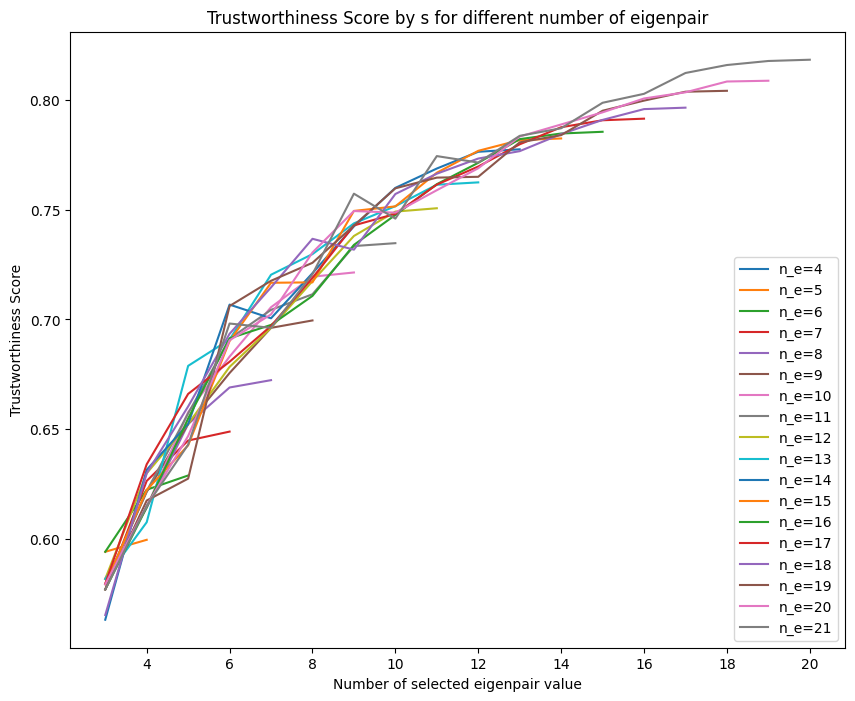

In [5]:

fixed_dataset_size=1000
min_num = 3
max_num = 22

plot_trust_vs_num_eigen(word_vectors,min_num,max_num,fixed_dataset_size)

# Finial choose parameter: n_eigenp=18,intrinsic_dim=15 for Diffusion map, svdtriplet=18,intrinsic_dim=15 for roseland

Finial choose parameter: 

n_eigenp=18,intrinsic_dim=15 for Diffusion map;

svdtriplet=18,intrinsic_dim=15 for Roseland

3 Accuracy (Trustworthiness)

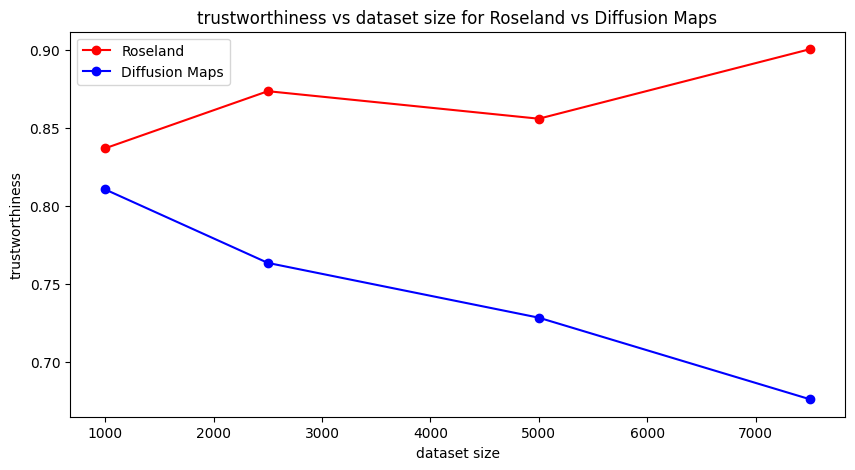

In [6]:

dataset_size = [1000,2500,5000,7500]
trustw_dms = []
trustw_rs = []
for N in dataset_size:
    X_pcm = preprocess_w2v(word_vectors,N)

    target_mapping_r = roseland(X_pcm,n_svdtriplet=18,intrinsic_dim=15)
    trustworthiness_score_r = trustworthiness(X_pcm, target_mapping_r)
    trustw_rs.append(trustworthiness_score_r)

    target_mapping_dm = diffusion(X_pcm,n_eigenp=18,intrinsic_dim=15)
    trustworthiness_score_dm = trustworthiness(X_pcm, target_mapping_dm)
    trustw_dms.append(trustworthiness_score_dm)

    trustworthiness_score_dm = trustworthiness(X_pcm, target_mapping_dm)
plot_vs(dataset_size,trustw_rs,trustw_dms,'dataset size',"trustworthiness",log_flag=False)

4 Robustnes to noise

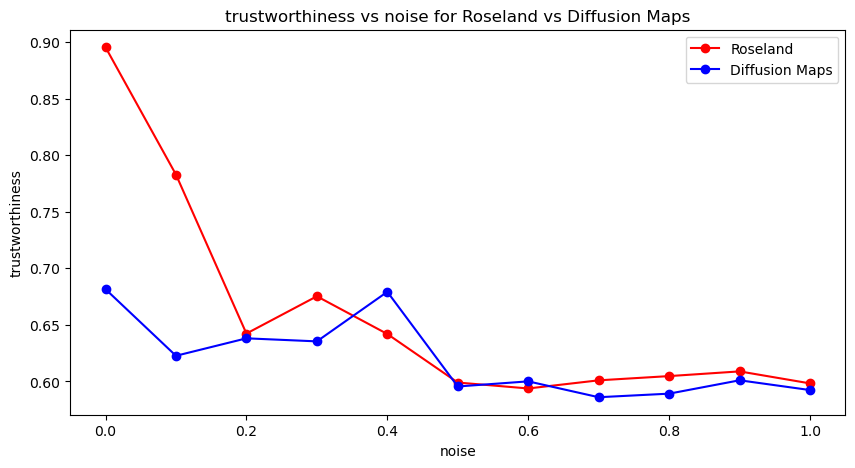

In [5]:

noises = np.arange(0,1.1,0.1)
trustw_dms = []
trustw_rs = []
fixed_dataset_set = 7500
for n in noises:
    X_pcm = preprocess_w2v(word_vectors,7500,noise=n)


    target_mapping_r = roseland(X_pcm,n_svdtriplet=18,intrinsic_dim=15)
    trustworthiness_score_r = trustworthiness(X_pcm, target_mapping_r)
    print(trustworthiness_score_r)
    trustw_rs.append(trustworthiness_score_r)



    target_mapping_dm = diffusion(X_pcm,n_eigenp=18,intrinsic_dim=15)
    trustworthiness_score_dm = trustworthiness(X_pcm, target_mapping_dm)
    print(trustworthiness_score_dm)
    trustw_dms.append(trustworthiness_score_dm)

    trustworthiness_score_dm = trustworthiness(X_pcm, target_mapping_dm)
plot_vs(noises,trustw_rs,trustw_dms,'noise',"trustworthiness",log_flag=False)